# Change to perturb-r root

In [6]:
cd /mnt/home/al2644/research/projects/perturb-r

/mnt/home/al2644/research/projects/perturb-r


In [7]:
import random
from fractions import Fraction
from typing import List, Tuple
import pandas as pd
from datasets import Dataset, DatasetDict

import pandas as pd 
import os 

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

import seaborn as sns

from datasets import load_dataset, load_from_disk
import numpy as np
import json

from utils.corrupt_num import *
from utils.chunk_r import *
import matplotlib.pyplot as plt

# Check Eval Dataset

In [68]:
dataset = load_from_disk("./data/countdown/")

# Reasoning Benchmark Eval

In [8]:
root = "./results/countdown/benchmark/"
for fname in os.listdir(root):
    if 'correct' not in fname:
        df = pd.read_pickle(os.path.join(root, fname))
        mean_acc = df['correct'].mean()
        print(f"Model: {fname.replace('.pickle', '')} Accuracy: {round(mean_acc, 2)}")

Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-100steps Accuracy: 0.4
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-150steps Accuracy: 0.42
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-200steps Accuracy: 0.41
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-250steps Accuracy: 0.41
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-300steps Accuracy: 0.43
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-350steps Accuracy: 0.42
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-400steps Accuracy: 0.35
Model: Qwen2.5-3B-countdown-level5-random_thought-only-stage2-50steps Accuracy: 0.37
Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-100steps Accuracy: 0.4
Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-150steps Accuracy: 0.42
Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-200steps Accuracy: 0.4
Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-250steps Accurac

In [14]:
def groupby_level (df):
    stats = df.groupby('level')['correct'].mean()
    answer_rate = df.groupby('level')['if_answer'].mean()
    result = pd.DataFrame({'acc': stats * 100})# , 'answer_rate': answer_rate * 100})
    return result

In [29]:
root = "./results/countdown/benchmark/"
model = "Qwen2.5-3B-countdown-level5-stage2-250steps"
df = pd.read_pickle(os.path.join(root, f"{model}.pickle"))

In [30]:
groupby_level(df)

,acc
level,
4,95.5
5,83.0
6,59.5
7,16.0
9,0.0
11,0.0
13,0.0


### visualization

In [55]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

root = "./results/countdown/benchmark/"
steps = [50, 100, 150, 200, 250]

# template → label (keep keys concise for legends)
templates = {
    "stage2"          : "Qwen2.5-3B-countdown-level5-stage2-{step}steps.pickle",
    "stage2-rand-thought"      : "Qwen2.5-3B-countdown-level5-random_thought-stage2-{step}steps.pickle",
    "stage2-rand-thought-only" : "Qwen2.5-3B-countdown-level5-random_thought-only-stage2-{step}steps.pickle",
}

# pick linestyles for the three model variants
dashes_map = {"stage2": "",         # solid
              "stage2-rand-thought": (2,2),  # dotted
              "stage2-rand-thought-only": (4,2)}  # dashed

In [60]:
baseline_files = {
    "sft-stage0"   : "Qwen2.5-3B-distill-countdown-level3-4-1epoch-stage0.pickle",
    "stage1-rl"  : "Qwen2.5-3B-grpo-countdown-level4-5-1epoch-stage1.pickle",
}

# give every *baseline* a distinct (long-dash) line style
dashes_map.update({k: (6,2) for k in baseline_files})   # e.g. – – – –

dashes_map.update({
    "sft-stage0" : (1, 1, 3, 1),   #   ·  — ·   —  (dash–dot)
    "stage1-rl"  : (8, 3, 2, 3),   #   ———   — ———   (long-short-long)
})

# ------------------------------------------------------------------
# 1.  LOAD EVERYTHING INTO ONE TIDY FRAME --------------------------
# ------------------------------------------------------------------
def collect_static(baseline_files):
    """Duplicate each baseline’s per-level metric across *all* steps so
       Seaborn treats them as horizontal lines.
    """
    out = []
    for model, rel_path in baseline_files.items():
        df  = pd.read_pickle(os.path.join(root, rel_path))
        g   = groupby_level(df).reset_index()            # level, acc, answer_rate
        for step in steps:                               # broadcast → every x-pos
            g_step = g.copy()
            g_step["step"]  = step
            g_step["model"] = model
            out.append(g_step)
    return pd.concat(out, ignore_index=True)

tidy_static = collect_static(baseline_files)

def collect_records():
    """Return tidy DataFrame with columns:
       step, model, level, acc, answer_rate
    """
    out = []
    for model, tmpl in templates.items():
        for step in steps:
            path = os.path.join(root, tmpl.format(step=step))
            df   = pd.read_pickle(path)
            g    = groupby_level(df).reset_index()     # cols: level, acc, answer_rate
            g["step"]  = step
            g["model"] = model
            out.append(g)
    return pd.concat(out, ignore_index=True)

tidy        = collect_records()
tidy_static = collect_static(baseline_files)
tidy        = pd.concat([tidy, tidy_static], ignore_index=True)   # ← merge

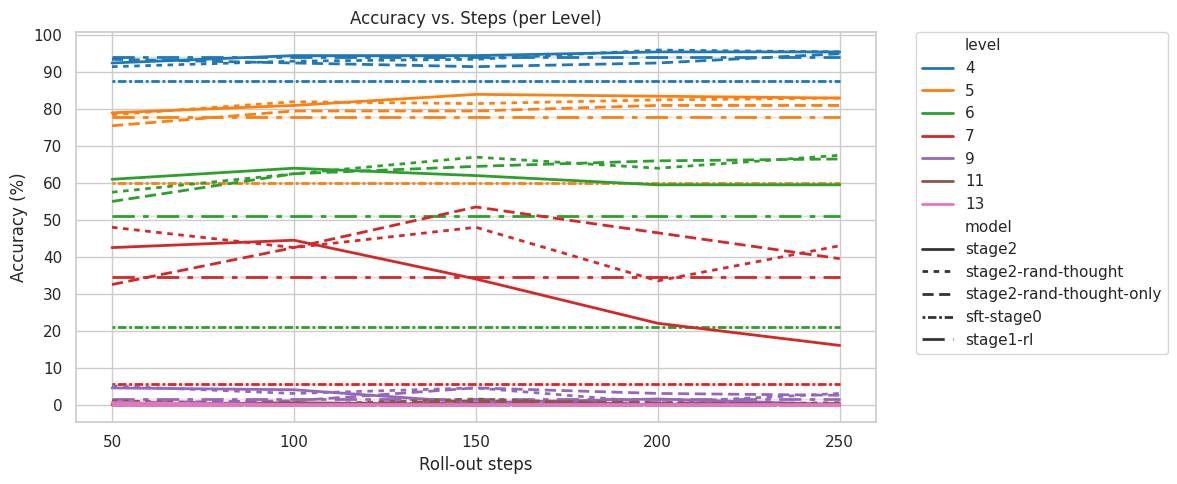

In [62]:

# ------------------------------------------------------------------
# PLOTTING  ---------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.0)

def lineplot(metric, ylabel, title):
    ax = sns.lineplot(
        data   = tidy,
        x      = "step",
        y      = metric,
        hue    = "level",      # color ↔ difficulty level
        style  = "model",      # linestyle ↔ model variant
        dashes = dashes_map,   # enforce our line styles
        palette= "tab10",
        linewidth = 2.0,
    )
    ax.set(
        xlabel = "Roll-out steps",
        ylabel = ylabel,
        title  = title,
    )
    ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_yticks(range(0, 101, 10)) 
    
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()

plt.figure(figsize=(12,5))
lineplot("acc", "Accuracy (%)", "Accuracy vs. Steps (per Level)")
plt.show()

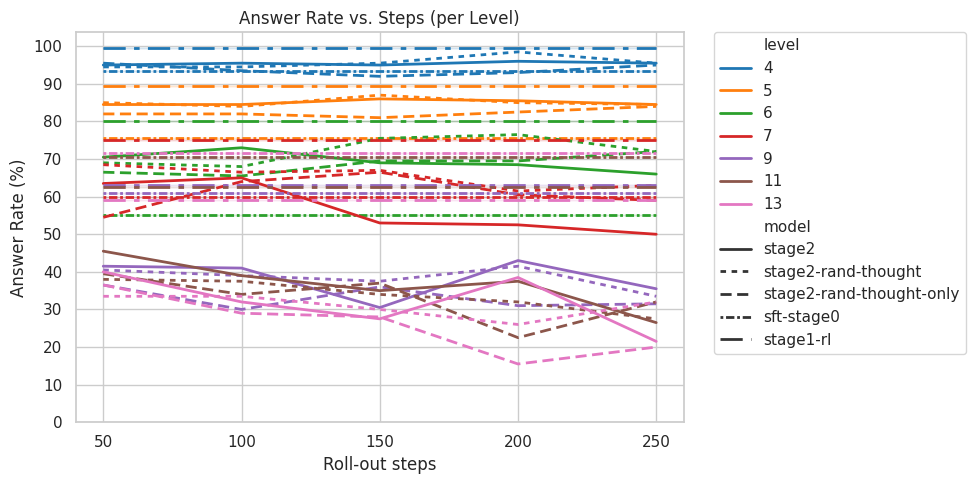

In [58]:
plt.figure(figsize=(10,5))
lineplot("answer_rate", "Answer Rate (%)", "Answer Rate vs. Steps (per Level)")
plt.show()

### Check reasoning patterns 

### Note:
    1. tricky questions: problems that can be solved by either using all numbers or subset of numbers
    2. didn't finish reasoning: this fluctuates a lot as well for w/ random thoughts

In [244]:
# Find problems solved by a model but not the other
correct_df = pd.read_pickle(os.path.join(root, 'Qwen2.5-3B-countdown-level5-random_thought-only-stage2-200steps.pickle'))
wrong_df = pd.read_pickle(os.path.join(root, 'Qwen2.5-3B-countdown-level5-random_thought-only-stage2-200steps.pickle'))
level = 7


correct_problems = correct_df[(correct_df['level'] == 7) & (correct_df['correct'] == 1.0)]['problem']
wrong_problems = wrong_df[(wrong_df['level'] == 7) & (wrong_df['correct'] == 0.0)]['problem']
problems = list(set(correct_problems).intersection(wrong_problems))

In [245]:
wrong_df[wrong_df['problem'].isin(wrong_problems)]['if_answer'].mean()

0.2616822429906542

In [253]:
example = wrong_df[wrong_df['problem'].isin(wrong_problems) & wrong_df['if_answer']].sample(n=1).iloc[0]

In [254]:
print(example['problem'])

Please reason and answer the following question. Using the numbers [16, 6, 21, 17, 77, 80, 80], create an equation that equals 50. You can only use basic arithmetic operations (+, -, *, /) in the expression and each number should be used exactly once. You should report the answer equation expression in <answer> </answer> tags, for example <answer> (1 + 2) / 3 </answer>.


In [255]:
print(example['response'])

<think>
Okay, let's see. I need to use the numbers 16, 6, 21, 17, 77, 80, and 80 exactly once each, with basic operations to make 50. Hmm, first, I should think about possible combinations. 

Let me start by looking at the numbers. There are two 80s. Maybe I can subtract them somehow? Like 80 - 80 is 0, but then I have to use the other numbers. Alternatively, maybe adding them? 80 + 80 is 160. That seems too big. Maybe subtract something else?

Another approach: think about the target number, 50. Let's see. What operations can get me there? Let's try different operations.

What if I take 80 - 77? That gives 3. Then maybe 80 - 17 is 63. Not sure. Alternatively, 80 - 6 is 74. Not helpful. Maybe 77 - 6 is 71. Hmm.

Wait, maybe combining numbers. Let's think of possible pairs. For example, 80 - 16 is 64. Then 64 minus something? 64 - 17 is 47. Then 47 plus 6 is 53. Not 50. Not helpful.

Alternatively, 80 divided by something? Like 80 divided by 16 is 5. Then maybe 5 multiplied by something

In [256]:
(77 - 16 - 17 + 6) + 80 - 80

50

# Corrupted Numbers

In [9]:
path = "./results/countdown/stress_test_problems.json"
problems = json.load(open(path))
print("number corruption tested on: ", len(problems), ' problems')

number corruption tested on:  250  problems


In [31]:
root = "./results/countdown/corrupt_numbers_fixed_window/"
    
for fname in os.listdir(root):
    print(fname)
    df = pd.read_pickle(os.path.join(root, fname))
    print(f"Accuracy: {df['still_correct'].mean()}")

Qwen2.5-3B-countdown-level5-random_thought-only-stage2-100steps.pickle
Accuracy: 0.797
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-150steps.pickle
Accuracy: 0.8185
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-200steps.pickle
Accuracy: 0.8605
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-250steps.pickle
Accuracy: 0.8825
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-300steps.pickle
Accuracy: 0.8945
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-350steps.pickle
Accuracy: 0.8985
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-400steps.pickle
Accuracy: 0.9225
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-50steps.pickle
Accuracy: 0.7825
Qwen2.5-3B-countdown-level5-random_thought-stage2-100steps.pickle
Accuracy: 0.7905
Qwen2.5-3B-countdown-level5-random_thought-stage2-150steps.pickle
Accuracy: 0.8385
Qwen2.5-3B-countdown-level5-random_thought-stage2-200steps.pickle
Accuracy: 0.873
Qwen2.5-3B-countdown-level5-random_thought-stage2-

In [48]:
df = pd.read_pickle(os.path.join(root, 'Qwen2.5-3B-countdown-level5-stage2-250steps.pickle'))

In [33]:
def groupby_level (df):
    stats = df.groupby('start_pos')['still_correct'].mean()
    result = pd.DataFrame({'acc': stats * 100})
    return result

In [49]:
groupby_level(df)

,acc
start_pos,
0.00,16.2
0.25,93.6
0.50,96.0
0.75,79.0


### visualization

In [76]:
root = "./results/countdown/corrupt_numbers_fixed_window/"
steps = [50, 100, 150, 200, 250]

# template → label (keep keys concise for legends)
templates = {
    "stage2"          : "Qwen2.5-3B-countdown-level5-stage2-{step}steps.pickle",
    "stage2-rand-thought"      : "Qwen2.5-3B-countdown-level5-random_thought-stage2-{step}steps.pickle",
    "stage2-rand-thought-only" : "Qwen2.5-3B-countdown-level5-random_thought-only-stage2-{step}steps.pickle",
}

# pick linestyles for the three model variants
dashes_map = {"stage2": "",         # solid
              "stage2-rand-thought": (2,2),  # dotted
              "stage2-rand-thought-only": (4,2)}  # dashed

In [90]:
baseline_files = {
    "sft-stage0"   : "Qwen2.5-3B-distill-countdown-level3-4-1epoch-stage0.pickle",
    "stage1-rl"  : "Qwen2.5-3B-grpo-countdown-level4-5-1epoch-stage1.pickle",
}

# give every *baseline* a distinct (long-dash) line style
dashes_map.update({k: (6,2) for k in baseline_files})   # e.g. – – – –

dashes_map.update({
    "sft-stage0" : (1, 1, 3, 1),   #   ·  — ·   —  (dash–dot)
    "stage1-rl"  : (8, 3, 2, 3),   #   ———   — ———   (long-short-long)
})

# ------------------------------------------------------------------
# 1.  LOAD EVERYTHING INTO ONE TIDY FRAME --------------------------
# ------------------------------------------------------------------
def collect_static(baseline_files):
    """Duplicate each baseline’s per-level metric across *all* steps so
       Seaborn treats them as horizontal lines.
    """
    out = []
    for model, rel_path in baseline_files.items():
        df  = pd.read_pickle(os.path.join(root, rel_path))
        g   = groupby_level(df).reset_index()            # level, acc, answer_rate
        for step in steps:                               # broadcast → every x-pos
            g_step = g.copy()
            g_step["step"]  = step
            g_step["model"] = model
            out.append(g_step)
    return pd.concat(out, ignore_index=True)

tidy_static = collect_static(baseline_files)

def collect_records():
    """Return tidy DataFrame with columns:
       step, model, level, acc, answer_rate
    """
    out = []
    for model, tmpl in templates.items():
        for step in steps:
            path = os.path.join(root, tmpl.format(step=step))
            df   = pd.read_pickle(path)
            g    = groupby_level(df).reset_index()     # cols: level, acc, answer_rate
            g["step"]  = step
            g["model"] = model
            out.append(g)
    return pd.concat(out, ignore_index=True)

tidy_static = collect_static(baseline_files)
tidy = collect_records()
tidy        = pd.concat([tidy, tidy_static], ignore_index=True)   # ← merge

In [91]:
tidy = tidy[tidy['start_pos'] == .75]

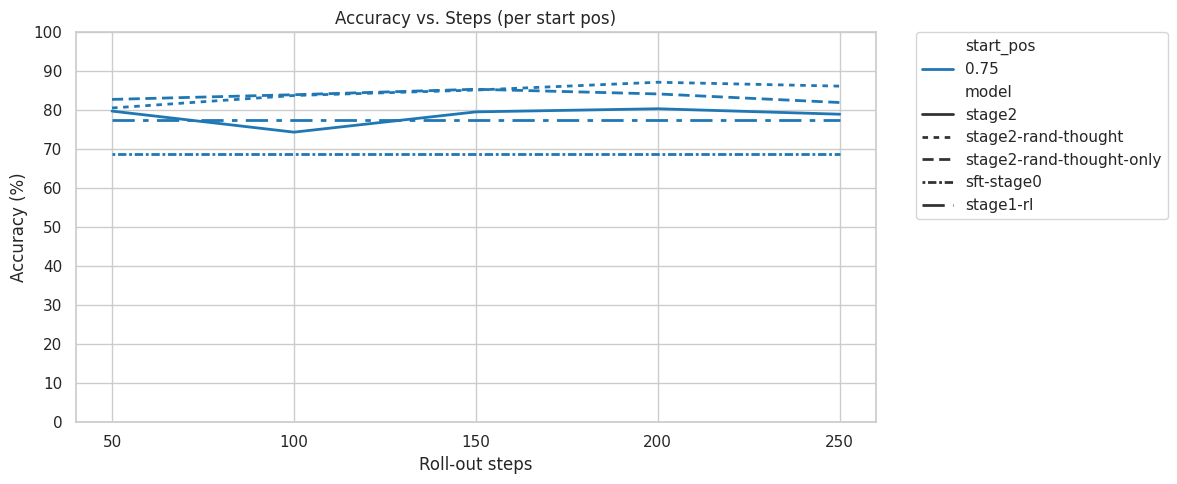

In [92]:

# ------------------------------------------------------------------
# PLOTTING  ---------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.0)

def lineplot(metric, ylabel, title):
    ax = sns.lineplot(
        data   = tidy,
        x      = "step",
        y      = metric,
        hue    = "start_pos",      # color ↔ difficulty level
        style  = "model",      # linestyle ↔ model variant
        dashes = dashes_map,   # enforce our line styles
        palette= "tab10",
        linewidth = 2.0,
    )
    ax.set(
        xlabel = "Roll-out steps",
        ylabel = ylabel,
        title  = title,
    )
    ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_yticks(range(0, 101, 10)) 
    
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()

plt.figure(figsize=(12,5))
lineplot("acc", "Accuracy (%)", "Accuracy vs. Steps (per start pos)")
plt.show()

# OOD questions

In [276]:
root='./results/countdown_ood_question/benchmark'
for fname in os.listdir(root):
    if 'correct' not in fname:
        df = pd.read_pickle(os.path.join(root, fname))
        mean_acc = df['correct'].mean()
        print(f"Model: {fname.replace('.pickle', '')} Accuracy: {round(mean_acc, 2)}")

Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-100steps Accuracy: 0.15
Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-200steps Accuracy: 0.14
Model: Qwen2.5-3B-countdown-level5-random_thought-stage2-250steps Accuracy: 0.16
Model: Qwen2.5-3B-countdown-level5-stage2-100steps Accuracy: 0.14
Model: Qwen2.5-3B-countdown-level5-stage2-200steps Accuracy: 0.13
Model: Qwen2.5-3B-countdown-level5-stage2-50steps Accuracy: 0.14
Model: Qwen2.5-3B-distill-countdown-level3-4-1epoch-stage0 Accuracy: 0.1
Model: Qwen2.5-3B-grpo-countdown-level4-5-1epoch-stage1 Accuracy: 0.12


In [279]:
df = pd.read_pickle(os.path.join(root, f"Qwen2.5-3B-countdown-level5-stage2-{step}steps.pickle"))
groupby_level(df)

,acc,answer_rate
level,,
4,19.5,29.5
5,18.0,27.0
6,20.0,27.5
7,7.0,37.5
9,0.5,37.0


# Distractor Injection

In [50]:
root = "./results/countdown/inject_distractor/"


for fname in os.listdir(root):
    print(fname)
    df = pd.read_pickle(os.path.join(root, fname))
    print(f"Original Accuracy: {df['original_correct'].mean()}")
    print(f"Distractor Accuracy: {df['distractor_correct'].mean()}")
    print("=" * 50)

Qwen2.5-3B-countdown-level5-random_thought-only-stage2-100steps.pickle
Original Accuracy: 0.722554347826087
Distractor Accuracy: 0.2298913043478261
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-150steps.pickle
Original Accuracy: 0.7573369565217392
Distractor Accuracy: 0.1983695652173913
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-200steps.pickle
Original Accuracy: 0.7668478260869566
Distractor Accuracy: 0.2095108695652174
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-250steps.pickle
Original Accuracy: 0.7663043478260869
Distractor Accuracy: 0.21358695652173912
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-300steps.pickle
Original Accuracy: 0.8467391304347827
Distractor Accuracy: 0.13668478260869565
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-350steps.pickle
Original Accuracy: 0.8456521739130435
Distractor Accuracy: 0.13260869565217392
Qwen2.5-3B-countdown-level5-random_thought-only-stage2-400steps.pickle
Original Accuracy: 0.878532608695

In [79]:
df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-countdown-level5-stage2-250steps.pickle"))
df=df[df['distractor_ratio']==0.25]

In [77]:
def groupby_level (df):
    stats = df.groupby('original_ratio')['original_correct'].mean()
    result = pd.DataFrame({'acc': stats })
    return result

In [80]:
groupby_level(df)

,acc
original_ratio,
0.00,0.082609
0.25,0.917391
0.50,0.830435
0.75,0.669565


In [66]:
df.groupby(['original_ratio', 'distractor_ratio'])[['original_correct', 'distractor_correct']].mean()

original_correct  distractor_correct
original_ratio distractor_ratio                                      
0.00           0.25                      0.817391            0.047826
               0.50                      0.734783            0.178261
               0.75                      0.639130            0.286957
               1.00                      0.208696            0.791304
0.25           0.25                      0.995652            0.000000
               0.50                      0.973913            0.017391
               0.75                      0.986957            0.004348
               1.00                      0.743478            0.252174
0.50           0.25                      0.995652            0.004348
               0.50                      0.978261            0.013043
               0.75                      0.956522            0.021739
               1.00                      0.747826            0.247826
0.75           0.25                      0.969565            0.021739
               0.50                      0.943478            0.056522
               0.75                      0.965217            0.030435
               1.00                      0.752174            0.243478

In [96]:
df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-distill-countdown-level3-4-1epoch-stage0.pickle"))

In [97]:
df.groupby(['original_ratio', 'distractor_ratio'])[['original_correct', 'distractor_correct']].mean()

original_correct  distractor_correct
original_ratio distractor_ratio                                      
0.00           0.25                      0.152174            0.686957
               0.50                      0.095652            0.795652
               0.75                      0.082609            0.856522
               1.00                      0.021739            0.978261
0.25           0.25                      0.795652            0.117391
               0.50                      0.739130            0.156522
               0.75                      0.556522            0.386957
               1.00                      0.195652            0.786957
0.50           0.25                      0.673913            0.256522
               0.50                      0.604348            0.269565
               0.75                      0.482609            0.456522
               1.00                      0.156522            0.817391
0.75           0.25                      0.578261            0.339130
               0.50                      0.482609            0.478261
               0.75                      0.413043            0.547826
               1.00                      0.126087            0.865217

In [102]:
df = pd.read_pickle(os.path.join(root, "Qwen2.5-3B-countdown-level5-stage2-250steps.pickle"))

In [103]:
df.groupby(['original_ratio', 'distractor_ratio'])[['original_correct', 'distractor_correct']].mean()

original_correct  distractor_correct
original_ratio distractor_ratio                                      
0.00           0.25                      0.082609            0.682609
               0.50                      0.043478            0.786957
               0.75                      0.017391            0.947826
               1.00                      0.008696            0.982609
0.25           0.25                      0.917391            0.017391
               0.50                      0.908696            0.026087
               0.75                      0.808696            0.121739
               1.00                      0.239130            0.730435
0.50           0.25                      0.830435            0.073913
               0.50                      0.817391            0.108696
               0.75                      0.760870            0.165217
               1.00                      0.247826            0.730435
0.75           0.25                      0.669565            0.213043
               0.50                      0.708696            0.213043
               0.75                      0.613043            0.313043
               1.00                      0.213043            0.782609

### visualization

In [98]:
def groupby_level (df):
    stats = df[["original_correct"]].mean()
    result = pd.DataFrame({'acc': stats * 100})
    return result

In [99]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

root = "./results/countdown/inject_distractor/"
steps = [50, 100, 150, 200, 250]

# template → label (keep keys concise for legends)
templates = {
    "stage2"          : "Qwen2.5-3B-countdown-level5-stage2-{step}steps.pickle",
    "stage2-rand-thought"      : "Qwen2.5-3B-countdown-level5-random_thought-stage2-{step}steps.pickle",
    "stage2-rand-thought-only" : "Qwen2.5-3B-countdown-level5-random_thought-only-stage2-{step}steps.pickle",
}

# pick linestyles for the three model variants
dashes_map = {"stage2": "",         # solid
              "stage2-rand-thought": (2,2),  # dotted
              "stage2-rand-thought-only": (4,2)}  # dashed

In [100]:
baseline_files = {
    "sft-stage0"   : "Qwen2.5-3B-distill-countdown-level3-4-1epoch-stage0.pickle",
    "stage1-rl"  : "Qwen2.5-3B-grpo-countdown-level4-5-1epoch-stage1.pickle",
}

# give every *baseline* a distinct (long-dash) line style
dashes_map.update({k: (6,2) for k in baseline_files})   # e.g. – – – –

dashes_map.update({
    "sft-stage0" : (1, 1, 3, 1),   #   ·  — ·   —  (dash–dot)
    "stage1-rl"  : (8, 3, 2, 3),   #   ———   — ———   (long-short-long)
})

# ------------------------------------------------------------------
# 1.  LOAD EVERYTHING INTO ONE TIDY FRAME --------------------------
# ------------------------------------------------------------------
def collect_static(baseline_files):
    """Duplicate each baseline’s per-level metric across *all* steps so
       Seaborn treats them as horizontal lines.
    """
    out = []
    for model, rel_path in baseline_files.items():
        df  = pd.read_pickle(os.path.join(root, rel_path))
        g   = groupby_level(df).reset_index()            # level, acc, answer_rate
        for step in steps:                               # broadcast → every x-pos
            g_step = g.copy()
            g_step["step"]  = step
            g_step["model"] = model
            out.append(g_step)
    return pd.concat(out, ignore_index=True)

tidy_static = collect_static(baseline_files)

def collect_records():
    """Return tidy DataFrame with columns:
       step, model, level, acc, answer_rate
    """
    out = []
    for model, tmpl in templates.items():
        for step in steps:
            path = os.path.join(root, tmpl.format(step=step))
            df   = pd.read_pickle(path)
            g    = groupby_level(df).reset_index()     # cols: level, acc, answer_rate
            g["step"]  = step
            g["model"] = model
            out.append(g)
    return pd.concat(out, ignore_index=True)

tidy        = collect_records()
tidy_static = collect_static(baseline_files)
tidy        = pd.concat([tidy, tidy_static], ignore_index=True)   # ← merge

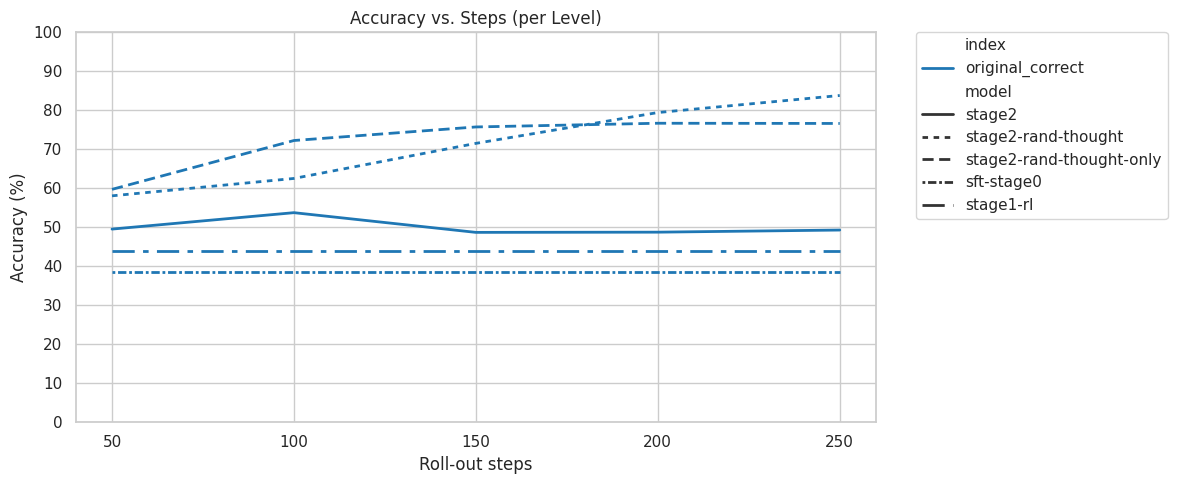

In [64]:

# ------------------------------------------------------------------
# PLOTTING  ---------------------------------------------------------
sns.set_theme(style="whitegrid", font_scale=1.0)

def lineplot(metric, ylabel, title):
    ax = sns.lineplot(
        data   = tidy,
        x      = "step",
        y      = metric,
        hue    = "index",      # color ↔ difficulty level
        style  = "model",      # linestyle ↔ model variant
        dashes = dashes_map,   # enforce our line styles
        palette= "tab10",
        linewidth = 2.0,
    )
    ax.set(
        xlabel = "Roll-out steps",
        ylabel = ylabel,
        title  = title,
    )
    ax.set_xticks([50, 100, 150, 200, 250])
    ax.set_yticks(range(0, 101, 10)) 
    
    ax.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.)
    plt.tight_layout()

plt.figure(figsize=(12,5))
lineplot("acc", "Accuracy (%)", "Accuracy vs. Steps (per Level)")
plt.show()

# ToDo Notes

In [ ]:
evals
    0. same set of stress tests for both math and countdown
    1. if observations on countdown and math are consistent
    2. if the corruption happens in the first chunk
    3. check the eval results for sft 3 epoch

In [ ]:
training todo:
    
    mix original question and corrupted prefix
    1. collect offline rl prefix ==> rl (save checkpoints for later eval)
    2. rl on same flops ==> same number of problems (assuming problems i.i.d)
    3. 1st rl collect for rejection sampling
    
    
generalization:
    1. different types of corruption (distractor injection, just wrong answer at the end)
    2. different degrees of digit corruption
    3. different task complexity
    
